# Graph cleaning


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

See the [guide](https://cityseer.benchmarkurbanism.com/guide) for a preamble.

Please also see the [`graph corrections`](https://cityseer.benchmarkurbanism.com/guide#graph-corrections) guide for an alternative approach.


## Downloading data

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API). To keep things interesting, let's pick London Soho, which will be buffered and cleaned for a 1,250m radius.


In [2]:
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# Let's download data within a 1,250m buffer around London Soho:
lng, lat = -0.13396079424572427, 51.51371088849723
# lng, lat = 2.166981, 41.389526 -- Barcelona - which is a complex case
buffer = 1250
# creates a WGS shapely polygon
poly_wgs, _poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(
    lng, lat, buffer
)
# use a WGS shapely polygon to download information from OSM
# this version will not simplify
G_raw = io.osm_graph_from_poly(poly_wgs, simplify=False)
# whereas this version does simplify
G_utm = io.osm_graph_from_poly(poly_wgs)

# select extents for clipping the plotting extents
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buff.bounds


# reusable plot function
def simple_plot(_G, plot_geoms=True):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=plot_geoms,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )

INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 12082/12082 [00:00<00:00, 429840.20it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 13423/13423 [00:00<00:00, 810949.12it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 13423/13423 [00:00<00:00, 71676.92it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 12082/12082 [00:01<00:00, 6103.29it/s]
INFO:cityseer.tools.graphs:Ironing edges.
100%|██████████| 5588/5588 [00:02<00:00, 2297.19it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 5588/5588 [00:00<00:00, 49894.99it/s]
INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y 

The automated graph cleaning may give satisfactory results depending on the intended end-use. See the steps following beneath for an example of how to manually clean the graph where additional control is preferred.


INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


The graph before simplification.


100%|██████████| 5554/5554 [00:00<00:00, 13094.12it/s]


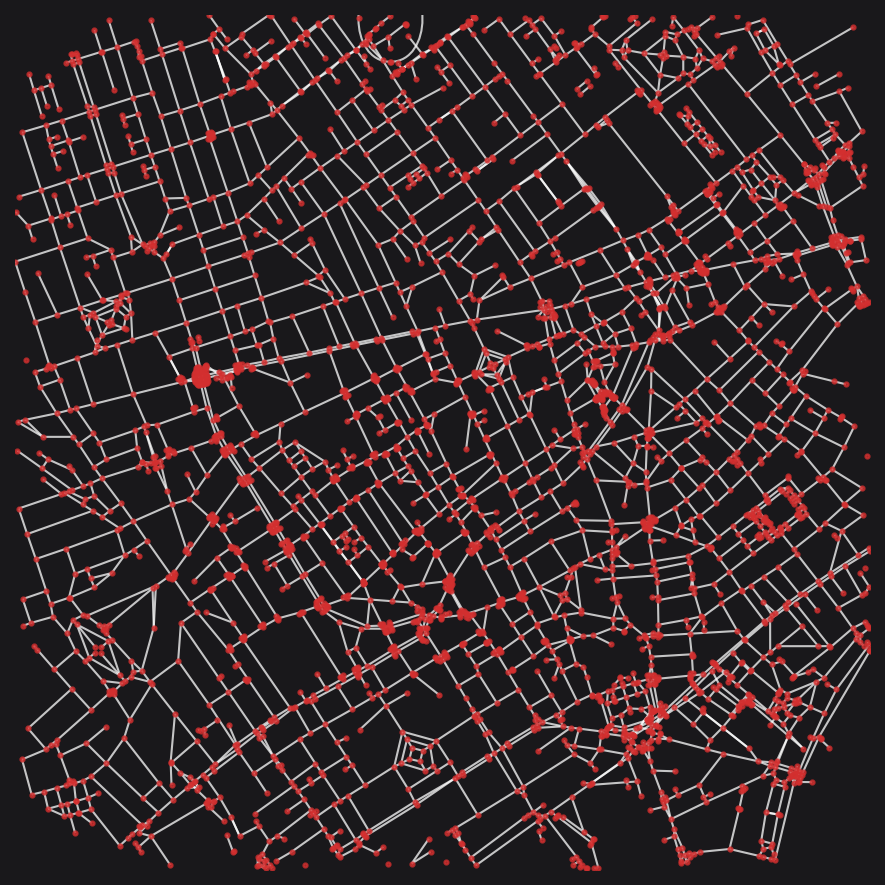

INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges


The graph after simplification


100%|██████████| 2629/2629 [00:00<00:00, 22692.72it/s]


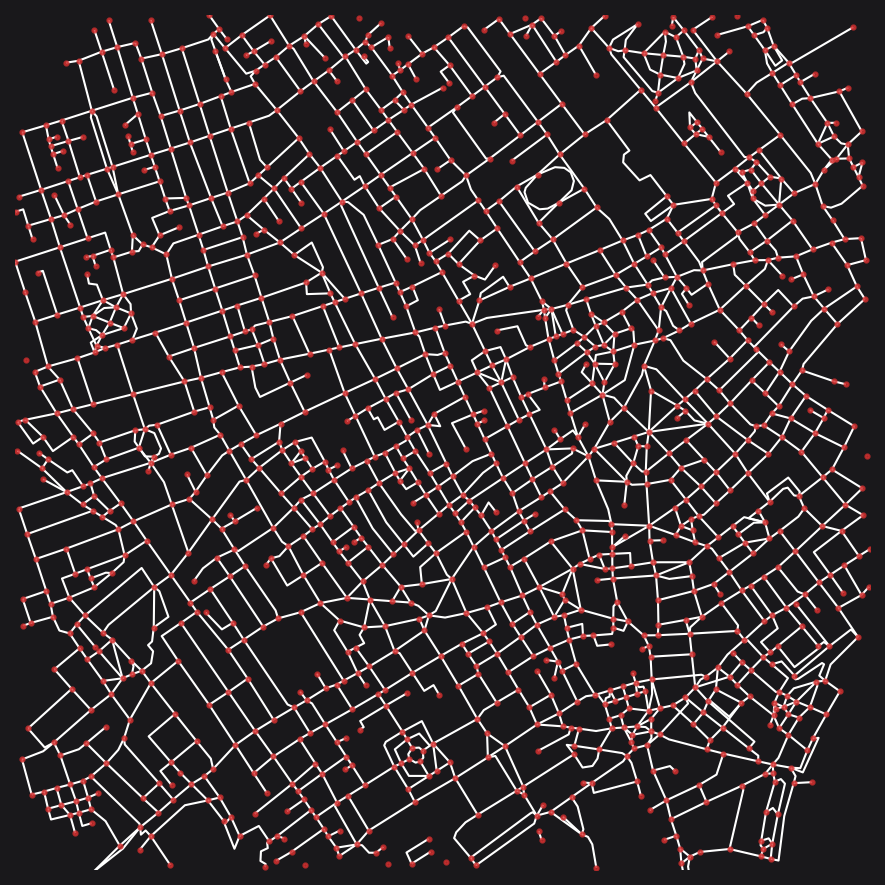

In [3]:
print("The graph before simplification.")
simple_plot(G_raw, plot_geoms=False)

print("The graph after simplification")
simple_plot(G_utm, plot_geoms=True)

## Deducing the network topology

Once OSM data has been converted to a `NetworkX` `MultiGraph`, the `tools.graphs` module can be used to clean the network.

> The convenience method used for this demonstration has already converted the graph from a geographic WGS to projected UTM coordinate system; however, if working with a graph which is otherwise in a WGS coordinate system then it must be converted to a projected coordinate system prior to further processing. This can be done with [`io.nx_wgs_to_utm`](/tools/io#nx-wgs-to-utm).

Now that raw OSM data has been loaded into a NetworkX graph, the `cityseer.tools.graph` methods can be used to further clean and prepare the network prior to analysis.

At this stage, the raw OSM graph is going to look a bit messy. Note how that nodes have been used to represent the roadway geometry. These nodes need to be removed and will be abstracted into `shapely` `LineString` geometries assigned to the respective street edges. So doing, the geometric representation will be kept distinct from the network topology.


INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4061/4061 [00:00<00:00, 152813.66it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3316/3316 [00:00<00:00, 24061.24it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 4329/4329 [00:00<00:00, 16390.34it/s]


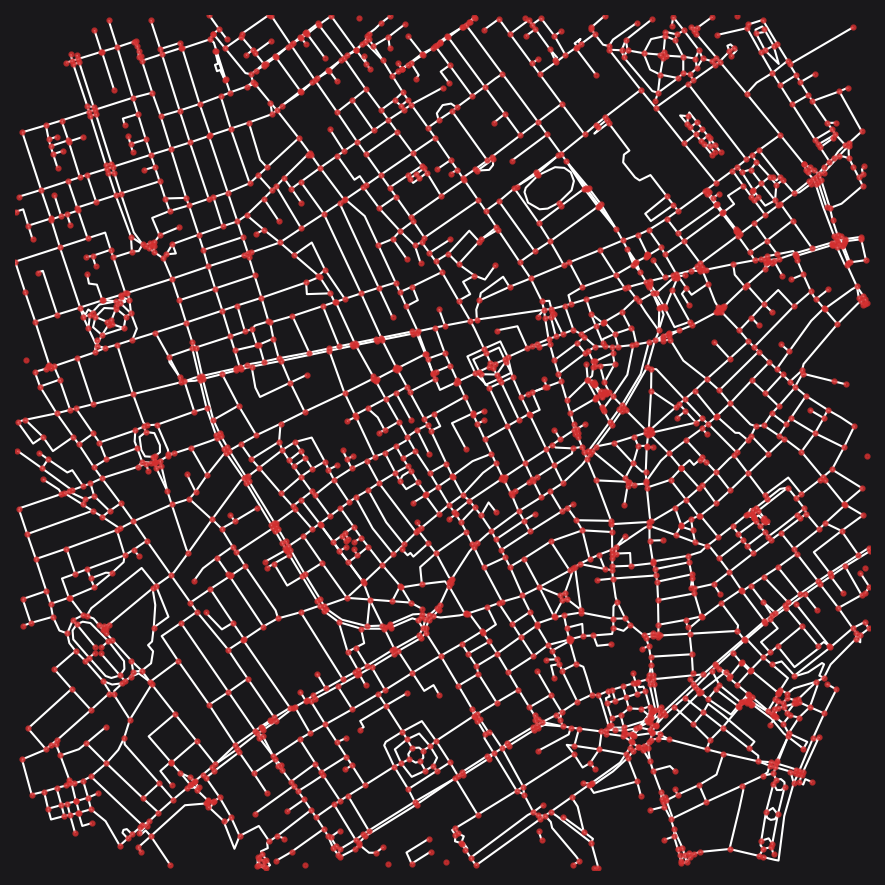

In [4]:
# remove dangling nodes: short dead-end stubs
# these are often found at entrances to buildings or parking lots
# The removed_disconnected flag will removed isolated network components
# i.e. disconnected portions of network that are not joined to the main street network
G = graphs.nx_remove_dangling_nodes(G_raw)
simple_plot(G)

## Refining the network

Things are already looked much better, but we still have areas with large concentrations of nodes at complex intersections and many parallel roadways, which will confound centrality methods. We'll now try to remove as much of this as possible. These steps involve the consolidation of nodes to clean-up extraneous nodes, which may otherwise exaggerate the intensity or complexity of the network in certain situations.

In this case, we're trying to get rid of parallel road segments so we'll do this in three steps, though it should be noted that, depending on your use-case, Step 1 may already be sufficient:


Step 1: An initial pass to cleanup complex intersections will be performed with the [`graphs.nx_consolidate_nodes`](/tools/graphs#nx-consolidate-nodes) function. The arguments passed to the parameters allow for a number of different strategies, such as whether to 'crawl'; whether to use intersection through routes for determining new centroids; and to set the direct or indirect neighbour policies according to which nodes and edges are consolidated. These are explained more fully in the documentation.


INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 2949/2949 [00:00<00:00, 48713.35it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 2949/2949 [00:01<00:00, 2479.86it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 1998/1998 [00:00<00:00, 72829.04it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 2967/2967 [00:00<00:00, 48658.66it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 2903/2903 [00:00<00:00, 23597.39it/s]


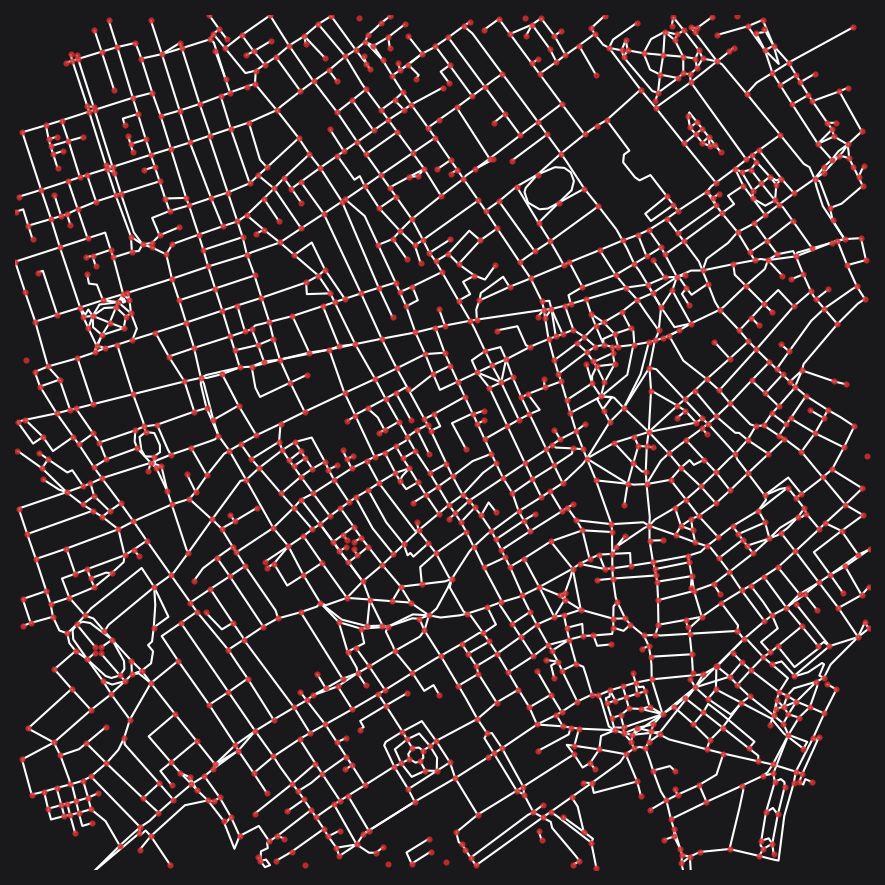

In [5]:
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=12, crawl=True)
simple_plot(G1)

Complex intersections have now been simplified. In Step 2, [`graphs.nx_split_opposing_geoms`](/tools/graphs#nx-split-opposing-geoms) is used to intentionally split edges in near proximity to nodes located on an adjacent parallel roadway. This helps with the final pass of consolidation in Step 3.


INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 2903/2903 [00:00<00:00, 495163.26it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 1927/1927 [00:01<00:00, 1741.87it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 3025/3025 [00:00<00:00, 187215.32it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 3025/3025 [00:00<00:00, 21370.57it/s]


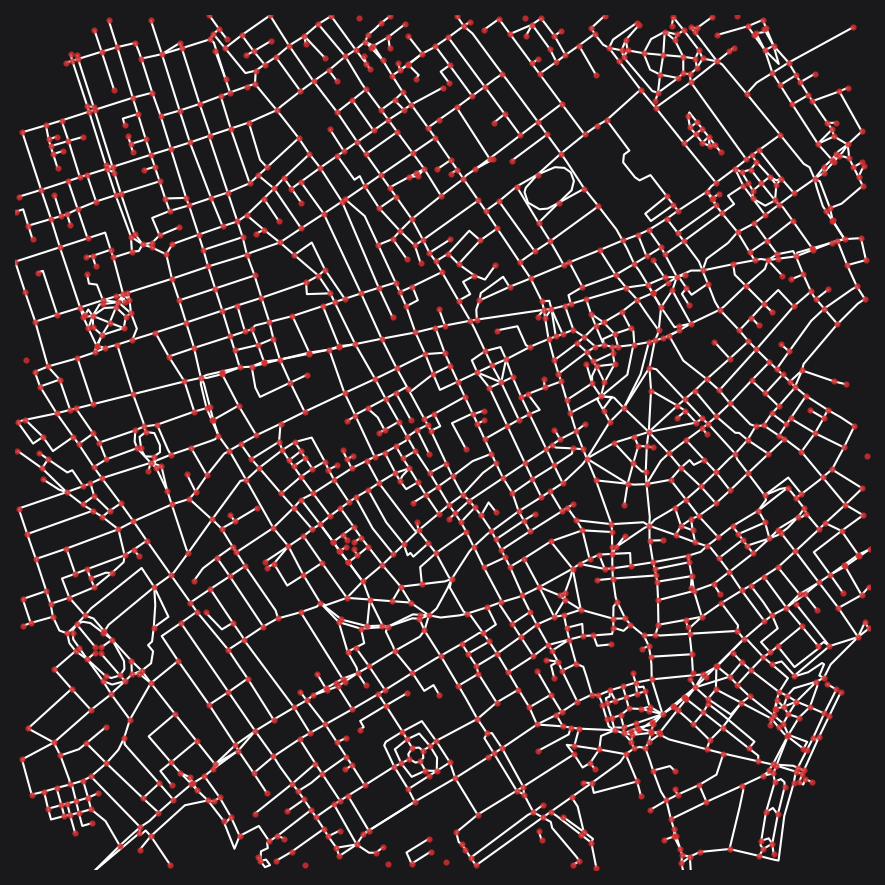

In [6]:
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
simple_plot(G2)

Rerun consolidation to clean up residual clusters of nodes.


INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 2049/2049 [00:00<00:00, 28973.43it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 2049/2049 [00:00<00:00, 4346.00it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 1785/1785 [00:00<00:00, 80253.32it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 2683/2683 [00:00<00:00, 54813.22it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 2645/2645 [00:00<00:00, 10681.90it/s]


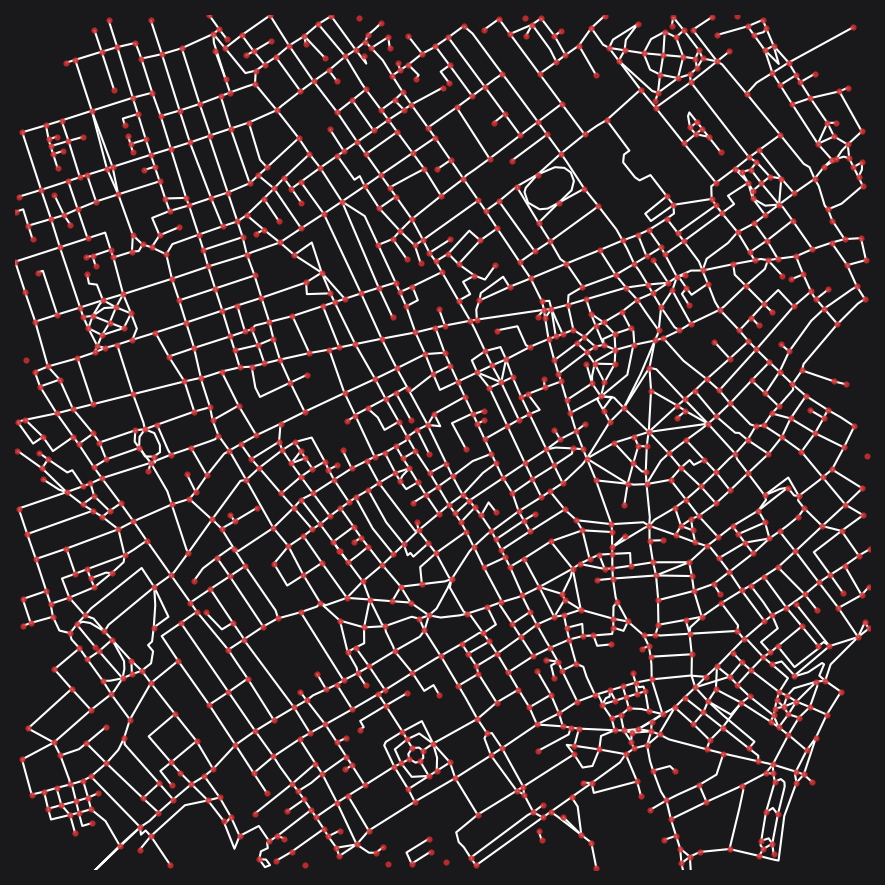

In [7]:
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15)
simple_plot(G3)

Finally, the edges are "ironed" to straighten out artefacts introduced by automated cleaning, which will sometimes bend the ends of edge segments to the locations of new centroids.


INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 1732/1732 [00:00<00:00, 201607.82it/s]
INFO:cityseer.tools.graphs:Ironing edges.
100%|██████████| 2640/2640 [00:00<00:00, 3053.51it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 2640/2640 [00:00<00:00, 163224.14it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 2640/2640 [00:00<00:00, 26706.03it/s]


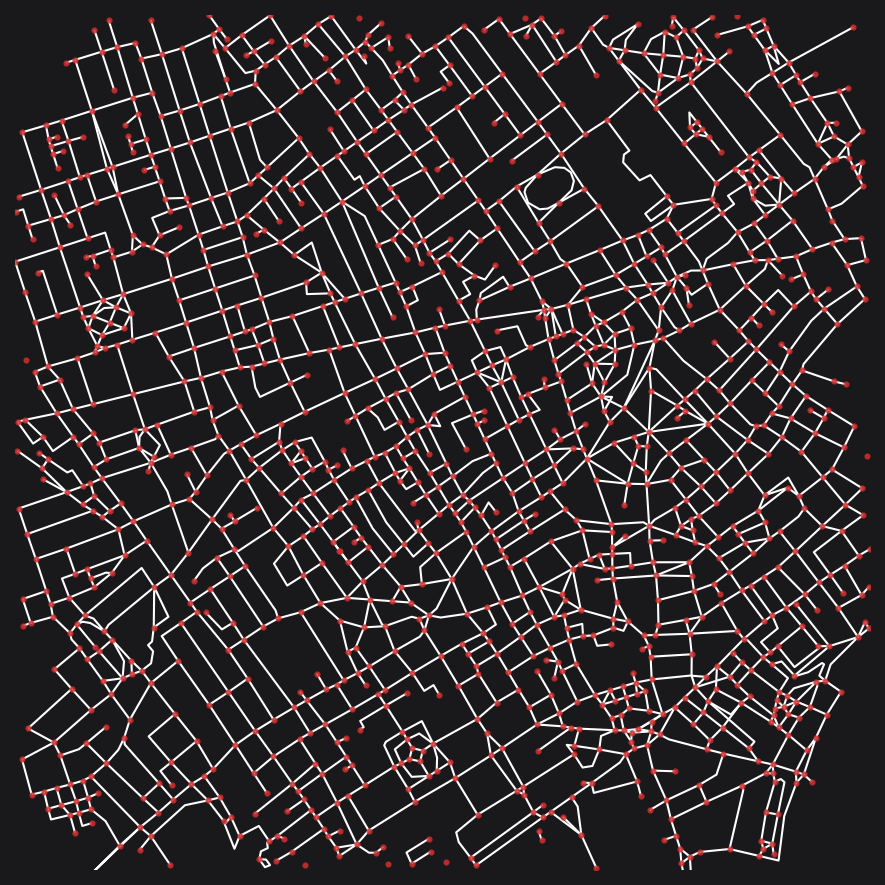

In [8]:
G4 = graphs.nx_remove_filler_nodes(G3)
G5 = graphs.nx_iron_edges(G4)
simple_plot(G5)